In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,accuracy_score
import os
from glob import glob
import random
from scipy.cluster.vq import kmeans,vq
from sklearn.svm import SVC

In [2]:
def Integral_img(img):
    n,m = img.shape[0:2]
    print(n,m)
    int_img = np.zeros((n,m))
    int_sum = np.zeros((n,m))
    for i in range(n):
        for j in range(m):
            if i-1>=0:
                int_sum[i][j]=int_sum[i-1][j]+img[i][j]
            else:
                int_sum[i][j]=img[i][j]
            if j-1>=0:
                int_img[i][j]=int_img[i][j-1]+int_sum[i][j]
            else:
                int_img[i][j]=int_sum[i][j]
    return int_img 

257 500


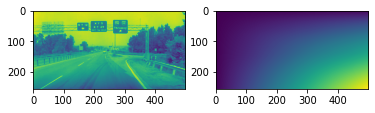

In [3]:
img = cv2.imread("../src/a.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.subplot(121)
plt.imshow(img)
img2 = Integral_img(img)
plt.subplot(122)
plt.imshow(img2)
plt.show()

In [4]:
img1 = Integral_img(img)
print(img1.shape)

257 500
(257, 500)


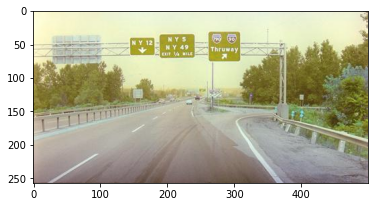

In [5]:
import cv2 as cv

original_image = cv.imread("../src/a.jpg")

grayscale_image = cv.cvtColor(original_image, cv.COLOR_BGR2GRAY)

face_cascade = cv.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

detected_faces = face_cascade.detectMultiScale(grayscale_image)
for (column, row, width, height) in detected_faces:
    cv.rectangle(original_image,(column, row),(column + width, row + height),(0, 255, 0),2)

plt.imshow(original_image)
plt.show()

# Part 2.. Scene Recognition using Bag of Visual Word

In [4]:
def find_paths(data_path,labels,num_train_img=80,num_test_img=20):
    print(data_path,"\n",labels)
    tr_img_path = []
    ts_img_path = []
    for label in labels:
        train_paths = glob(os.path.join(data_path,'train',label,'*.jpg'))

        for i in range(num_train_img):
            tr_img_path.append((train_paths[i],label))

        test_paths = glob(os.path.join(data_path,'test',label,'*.jpg'))
        for i in range(num_test_img):
            ts_img_path.append((test_paths[i],label))
    return tr_img_path, ts_img_path

In [5]:
labels = ['aquarium','desert','highway','kitchen','laundromat','park','waterfall','windmill']
IMAGE_FOLDER_PATH = "../dataset/SUN_data/SUN_data"
tr_img_path,ts_img_path= find_paths(IMAGE_FOLDER_PATH,labels,75,20)
len(tr_img_path),len(ts_img_path)

../dataset/SUN_data/SUN_data 
 ['aquarium', 'desert', 'highway', 'kitchen', 'laundromat', 'park', 'waterfall', 'windmill']


(600, 160)

In [7]:
random.shuffle(tr_img_path)
random.shuffle(ts_img_path)

In [8]:
print(tr_img_path[0],"\n",ts_img_path[0])

image_paths, y_train = zip(*tr_img_path)
image_paths_test, y_test = zip(*ts_img_path)

('../dataset/SUN_data/SUN_data/train/aquarium/sun_acjrhiyqadrbtovi.jpg', 'aquarium') 
 ('../dataset/SUN_data/SUN_data/test/waterfall/sun_bpwkqeughwjptkae.jpg', 'waterfall')


### Resize image (150,150)

In [9]:
image_paths[0],y_train[0]

('../dataset/SUN_data/SUN_data/train/aquarium/sun_acjrhiyqadrbtovi.jpg',
 'aquarium')

###  2.2.a & 2.2.b function  for calculate dense-SIFT features on the images and training  and  testing  images  ashistograms  of  visual  words 


In [53]:
def compute_des_list(image_paths):
    des_list = []
    shift = cv2.xfeatures2d.SIFT_create()
    for img_path in image_paths:
        img = cv2.imread(img_path)
        kp, des = shift.detectAndCompute(img, None)
        des_list.append((img_path,des))
    return des_list  

def compute_histogram(image_paths,voc,des_list):
    im_features=np.zeros((len(image_paths),k),"float32")
    for i in range(len(image_paths)):
        words,distance=vq(des_list[i][1],voc)
        for w in words:
            im_features[i][w]+=1
    return im_features

### computed descriptors of all train images 

In [54]:
des_list = compute_des_list(image_paths)
descriptors=des_list[0][1]
for image_path,descriptor in des_list[1:]:
    descriptors=np.vstack((descriptors,descriptor))

In [55]:
descriptors.shape

(514881, 128)

### 2.2.d clustering are done using kmeans on descriptors

In [56]:
descriptors_float=descriptors.astype(float)
k=300
voc,variance=kmeans(descriptors_float,k,1)

### 2.2.c computed histogram of all train images and Normalize the histogram using standardScaler

In [57]:
im_features=compute_histogram(image_paths,voc,des_list)
stdslr=StandardScaler().fit(im_features)
im_features=stdslr.transform(im_features)

### Plot Histogram

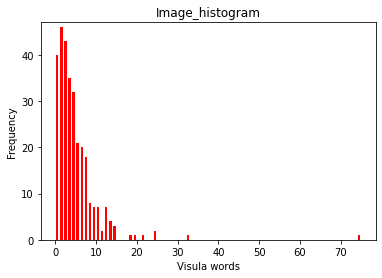

In [85]:
from collections import Counter
def plot_histogram(im_feat):
    counted = Counter(im_feat)
    max_freq = max(counted,key=counted.get)
    plt.hist(im_feat,bins=int(max(im_feat)),rwidth=0.6,color='red')
    axes = plt.gca()
    axes.set_ylim([0,counted[max_freq]+1])
    axes.set(title='Image_histogram')
    axes.set(xlabel="Visula words")
    axes.set(ylabel="Frequency")
im_features=compute_histogram(image_paths,voc,des_list)
plot_histogram(im_features[0])

### 2.2.c computed descriptors and histogram of all test images and Normalize the histogram using standardScaler

In [58]:
des_list_test = compute_des_list(image_paths_test) 
test_features=compute_histogram(image_paths_test,voc,des_list_test)
stdslr=StandardScaler().fit(test_features)
test_features=stdslr.transform(test_features)

In [59]:
from sklearn.model_selection import GridSearchCV
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                     'C': [0.001, 0.10, 10, 25, 50, 100, 1000]},
                    {'kernel': ['sigmoid'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                     'C': [0.001, 0.10, 10, 25, 50, 100, 1000]},
                    {'kernel': ['linear'], 'C': [0.001, 0.10, 10, 25, 50, 100, 1000]},
                    {'kernel':['poly'],'gamma': [1e-2, 1e-3, 1e-4, 1e-5],'degree':[1,2,3,5],'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]}
                   ]
scores = ['precision', 'recall']

for score in scores:
    clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=5,scoring='%s_macro' % score)
    clf.fit(im_features,np.array(y_train))

    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
% (mean, std * 2, params))

/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classifica

/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classifica

/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classifica

/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classifica

/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classifica

/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classifica

/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classifica

/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classifica

/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classifica

/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classifica

/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classifica

/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classifica

/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classifica

/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classifica

/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/navneet/.local/lib/python3.8/site-packages/sklearn/metrics/_classifica

0.503 (+/-0.175) for {'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}
0.449 (+/-0.049) for {'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}
0.427 (+/-0.203) for {'C': 0.001, 'gamma': 0.0001, 'kernel': 'rbf'}
0.437 (+/-0.212) for {'C': 0.001, 'gamma': 1e-05, 'kernel': 'rbf'}
0.503 (+/-0.175) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.474 (+/-0.105) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.427 (+/-0.203) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.437 (+/-0.212) for {'C': 0.1, 'gamma': 1e-05, 'kernel': 'rbf'}
0.643 (+/-0.103) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.683 (+/-0.073) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.630 (+/-0.023) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.472 (+/-0.141) for {'C': 10, 'gamma': 1e-05, 'kernel': 'rbf'}
0.643 (+/-0.103) for {'C': 25, 'gamma': 0.01, 'kernel': 'rbf'}
0.659 (+/-0.081) for {'C': 25, 'gamma': 0.001, 'kernel': 'rbf'}
0.660 (+/-0.081) for {'C': 25, 'gamma': 0.0001, 'kernel': 'rbf'}
0.545 (+/-0.043) for {'C

0.382 (+/-0.096) for {'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}
0.428 (+/-0.055) for {'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}
0.348 (+/-0.110) for {'C': 0.001, 'gamma': 0.0001, 'kernel': 'rbf'}
0.345 (+/-0.116) for {'C': 0.001, 'gamma': 1e-05, 'kernel': 'rbf'}
0.382 (+/-0.096) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.432 (+/-0.061) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.348 (+/-0.110) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.345 (+/-0.116) for {'C': 0.1, 'gamma': 1e-05, 'kernel': 'rbf'}
0.597 (+/-0.109) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.680 (+/-0.065) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.622 (+/-0.045) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.383 (+/-0.086) for {'C': 10, 'gamma': 1e-05, 'kernel': 'rbf'}
0.597 (+/-0.109) for {'C': 25, 'gamma': 0.01, 'kernel': 'rbf'}
0.660 (+/-0.077) for {'C': 25, 'gamma': 0.001, 'kernel': 'rbf'}
0.650 (+/-0.092) for {'C': 25, 'gamma': 0.0001, 'kernel': 'rbf'}
0.497 (+/-0.056) for {'C

In [60]:
clf.best_params_

{'C': 50, 'gamma': 0.0001, 'kernel': 'rbf'}

### 2.3 classification  by  training  one-vs-all  SVMs  using  sklearn on normalised data

In [61]:
clff=SVC(C=50,kernel='rbf',degree=1,gamma=0.0001,max_iter=100000)
clff.fit(im_features,np.array(y_train))

y_pred = clff.predict(test_features)
y_Test = np.array(y_test)

accuracy=accuracy_score(y_Test,y_pred)
print(accuracy)

0.65


### classification  by  training  one-vs-all  SVMs  using  sklearn on unnormalised data

In [78]:
im_features1=compute_histogram(image_paths,voc,des_list)
clf=SVC(C=50,kernel='rbf',gamma=0.001)
clf.fit(im_features1,np.array(y_train))

des_list_test = compute_des_list(image_paths_test) 
test_features1=compute_histogram(image_paths_test,voc,des_list_test)

y_pred1 = clf.predict(test_features1)
y_Test1 = np.array(y_test)

accuracy=accuracy_score(y_Test1,y_pred1)
print(accuracy)

0.525


### 2.4 Confustion matrix 

In [66]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
print("********************Confusition matrix on normalised dataset********************************\n")
print(confusion_matrix(y_true=y_Test, y_pred=y_pred))
print(classification_report(y_true=y_Test, y_pred=y_pred, labels=labels))
print("********************Confusition matrix on unnormalised dataset********************************\n")
print(confusion_matrix(y_true=y_Test1, y_pred=y_pred1))
print(classification_report(y_true=y_Test1, y_pred=y_pred1, labels=labels))

********************Confusition matrix on normalised dataset********************************

[[17  0  1  0  0  0  1  1]
 [ 0 15  1  0  0  0  2  2]
 [ 0  3 14  0  2  1  0  0]
 [ 2  0  0 16  2  0  0  0]
 [ 1  1  1  4 13  0  0  0]
 [ 2  1  1  0  0 11  2  3]
 [ 1  0  2  0  0  9  8  0]
 [ 0  6  0  0  1  2  1 10]]
              precision    recall  f1-score   support

    aquarium       0.74      0.85      0.79        20
      desert       0.58      0.75      0.65        20
     highway       0.70      0.70      0.70        20
     kitchen       0.80      0.80      0.80        20
  laundromat       0.72      0.65      0.68        20
        park       0.48      0.55      0.51        20
   waterfall       0.57      0.40      0.47        20
    windmill       0.62      0.50      0.56        20

    accuracy                           0.65       160
   macro avg       0.65      0.65      0.65       160
weighted avg       0.65      0.65      0.65       160

********************Confusition matrix

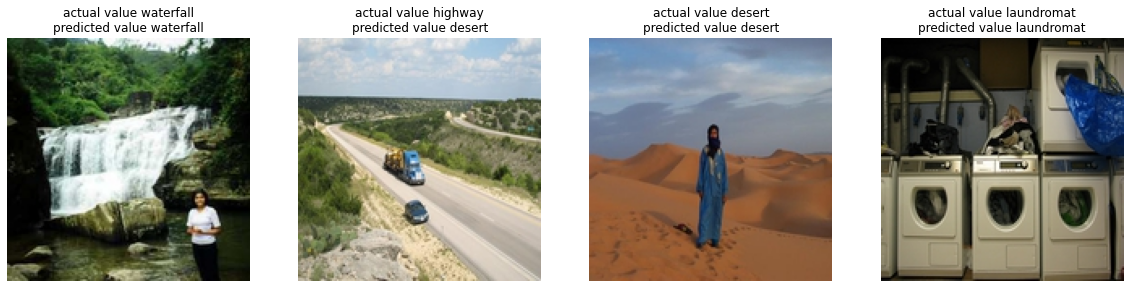

In [19]:
fig = plt.figure(figsize=(20,10))
plt.subplot(141)
plt.axis('off')
t1 = "actual value " + str(y_Test[0]) + "\npredicted value " + str(y_pred[0]) 
plt.title(t1)
im1 = cv2.cvtColor(cv2.imread(image_paths_test[19]),cv2.COLOR_BGR2RGB)
plt.imshow(im1)
plt.subplot(142)
plt.axis('off')
t2 = "actual value " + str(y_Test[1]) + "\npredicted value " + str(y_pred[1]) 
im2 = cv2.cvtColor(cv2.imread(image_paths_test[1]),cv2.COLOR_BGR2RGB)
plt.imshow(im2)
plt.title(t2)
plt.subplot(143)
plt.axis('off')
t3 = "actual value " + str(y_Test[2]) + "\npredicted value " + str(y_pred[2]) 
plt.title(t3)
im3 = cv2.cvtColor(cv2.imread(image_paths_test[2]),cv2.COLOR_BGR2RGB)
plt.imshow(im3)
plt.subplot(144)
plt.axis('off')
t4 = "actual value " + str(y_Test[3]) + "\npredicted value " + str(y_pred[3]) 
im4 = cv2.cvtColor(cv2.imread(image_paths_test[3]),cv2.COLOR_BGR2RGB)
plt.imshow(im4)
plt.title(t4)
plt.show()

### Linear

In [74]:
im_features=compute_histogram(image_paths,voc,des_list)
stdslr=StandardScaler().fit(im_features)
im_features=stdslr.transform(im_features)

clff=SVC(C=10,kernel='linear')
clff.fit(im_features,np.array(y_train))

y_pred = clff.predict(test_features)
y_Test = np.array(y_test)

accuracy=accuracy_score(y_Test,y_pred)
print(accuracy)

0.60625


In [127]:
tf_idf = tf*idf
tf_idf = np.nan_to_num(tf_idf)

<ipython-input-127-30c8030f46c5>:1: RuntimeWarning: invalid value encountered in multiply
  tf_idf = tf*idf


In [118]:
## calculation Term frequency

tf=np.zeros((len(image_paths),k),"float32")
tf= im_features/300


## calculating IDF
idf=np.zeros((len(image_paths),k),"float32")
for i in range(len(im_features)):
    for j in range(len(im_features[i])):
            idf[i][j]=  np.log(300/im_features[i][j])

<ipython-input-118-b40af4b85244>:11: RuntimeWarning: divide by zero encountered in true_divide
  idf[i][j]=  np.log(300/im_features[i][j])


In [112]:
im_features=compute_histogram(image_paths,voc,des_list)

### TF-IDF

In [128]:
clff=SVC(C=10,kernel='linear')
clff.fit(tf_idf,np.array(y_train))

y_pred = clff.predict(test_features)
y_Test = np.array(y_test)

accuracy=accuracy_score(y_Test,y_pred)
print(accuracy)

0.575
